
# Eigenvalue problems
.. index:: Equations; Eigenvalue problems

.. sectionauthor:: contribution by Philip J. Herbert <P.Herbert@sussex.ac.uk>

We use Dune and SciPy to compute the Eigenvalues and Eigenfunctions of the Laplace operator.

## Eigenvalues of the Neumann Laplacian

We first consider the simple problem that
$(u,\lambda)\in H^1(\Omega)\times{\mathbb{R}}$ satisfy
\begin{align*}
-\Delta u &= \lambda u  && \text{in } \Omega\\
\partial_\nu u &= 0     && \text{on } \partial \Omega
\end{align*}
As standard, we begin by importing ufl.
In addition, we import alugrid and consider the domain $(0,1)^2$ and refine:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from ufl import *
from dune.alugrid import aluSimplexGrid
vertices = np.array( [(0,0), (1,0), (1,1), (0,1),(0.5,0.5)] )
triangles = np.array( [(0,1,4), (1,2,4), (2,4,3), (3,4,0)] )
gridView = aluSimplexGrid({"vertices": vertices, "simplices": triangles})
gridView.hierarchicalGrid.globalRefine(4)

Introduce the space and test functions:

In [2]:
from dune.fem.space import lagrange
space = lagrange(gridView, order=1)
u = TrialFunction(space)
v = TestFunction(space)

To numerically solve the PDE eigenvalue problem with finite elements, we must consider a generalised eigenvalue problem.
That is, given matrices $A, M \in \mathbb{R}^{N\times N}$,
we are interested in finding pairs $(X,\lambda) \in \mathbb{R}^N \times \mathbb{R}$ such that
$$ A X = \lambda M X. $$
In this setting, $A$ is the stiffness matrix, $M$ the mass matrix, and $X$ will be the degrees of freedom vector.
We now assemble the matrices which export as scipy sparse objects:

In [3]:
from dune.fem import assemble
A = assemble( inner(grad(u),grad(v))*dx ).as_numpy
M = assemble( inner(u,v)*dx ).as_numpy

We use scipy to solve the eigen-problem, however first we must choose how many to find

In [4]:
from scipy.sparse.linalg import eigs
num_sols = 10
eigvals, eigvecs = eigs(A, M = M, sigma = 0, k = num_sols)

\texttt{sigma = 0} is used to find eigenvalues near 0, using shift-invert mode,
see [scipy.sparse.linalg.eigs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigs.html).
For more challenging, or intricate problems it may be desirable to use [slepc4py](https://slepc4py.readthedocs.io/en/stable/).
Let us compare the computed eigenvalues with known eigenvalues.

In [5]:
eigvals.real

array([-1.67817149e-14,  1.98023169e+01,  9.88689269e+00,  9.88689269e+00,
        3.98565801e+01,  3.98595797e+01,  4.98791485e+01,  4.98791485e+01,
        7.99664942e+01,  9.06848813e+01])

In [6]:
pairs = [ n**2 + m**2 for n in range(num_sols) for m in range(num_sols)]
pairs.sort()
reference_eigvals = [np.pi**2 * pair for pair in pairs[:num_sols] ]
reference_eigvals

[0.0,
 9.869604401089358,
 9.869604401089358,
 19.739208802178716,
 39.47841760435743,
 39.47841760435743,
 49.34802200544679,
 49.34802200544679,
 78.95683520871486,
 88.82643960980423]

We now want to assemble a list of finite element functions and distribute the contents of
`eigvecs` into it.

In [7]:
solutions = [space.function(name = "eigenvalue"+str(i)) for i in range(num_sols)]
for k in range(num_sols):
    solutions[k].as_numpy[:] = eigvecs[:,k].real

Let us note that we have chosen a symmetric problem therefore the solutions are real.

The eigenvectors may now be plotted using vtk files or matplotlib

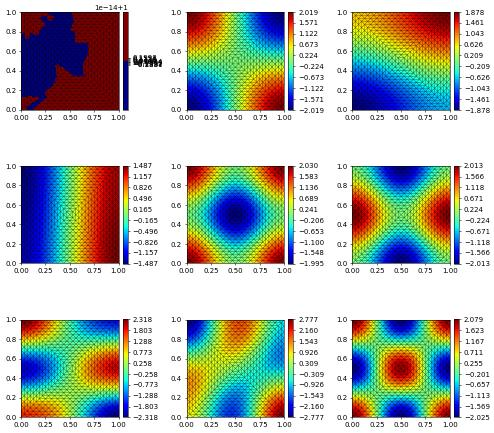

In [8]:
# gridView.writeVTK( "Neumann_Eigenvalues", pointdata = solutions )
rows, cols = num_sols//3, 3
fig, axs = plt.subplots(rows, cols, figsize=(10,10))
for k in range(rows):
    for l in range(cols):
        if k*cols+l < len(solutions):
            solutions[k*cols+l].plot( figure=(fig, axs[k][l]) )

## Dirichlet Eigenvalue problem

The calculation for the Dirichlet Eigenvalues is a little more intricate.
This is because when we adjust the LHS matrix and RHS matrix for the boundary conditions, the RHS matrix needs to be treated slightly different.
To begin, let us remind ourselves of the problem: find $(u,\lambda)\in H^1(\Omega)\times \mathbb{R}$ satisfy
\begin{align*}
-\Delta u &= \lambda u && \text{in } \Omega\\
u &= 0                 && \text{on } \partial \Omega
\end{align*}

For the moment, let us set up the new operators and save the original
mass matrix for later convenience:
The stiffness matrix can be setup as done previously. Note that the
Dirichlet constraints are applied by changing the corresponding rows to
unit vectors.

We will need information about the dirichlet degrees of freedom later on
so will not use the `assemble` function but use an `operator` for the
left hand side:

In [9]:
MassMatrix = M
from dune.fem.operator import galerkin
from dune.ufl import DirichletBC
dbc = DirichletBC(space,0)
LHSOp = galerkin([inner(grad(u),grad(v))*dx, dbc])
A = LHSOp.linear().as_numpy
M = assemble([inner(u,v)*dx, dbc]).as_numpy

For the mass matrix we need the diagonal entries associated with
the Dirichlet degrees of freedom to be $0$ instead of $1$. We describe
two approaches for achieving this.

Firstly we can introduce a dummy zero operator `RHSOpPerturbation` which will provide a matrix
which is the identity matrix on the boundary vertices and zero otherwise.
Since the mass matrix also has this identity sub-matrix subtracting the
two matrices achieves the desired outcome.

In [10]:
from dune.ufl import Constant
M = M - assemble([Constant(0)*inner(u,v)*dx, dbc]).as_numpy

.. index::
   triple: Boundary; Dirichlet; Degrees of Freedom

The second approach makes the desired change directly on the SciPy matrix.
We first extract the
[indices of the Dirichlet dofs](boundary_nb.ipynb#Accessing-the-Dirichlet-degrees-of-freedom)
and use those indices to setup a diagonal matrix $D$ similar to the first approach.
We could now subtract the two matrices as before but instead we multiply
$M$ with $D$ from both sides to change both rows and columns in $M$ to zero.

In [11]:
import scipy.sparse as sps
M = assemble([inner(u,v)*dx, dbc]).as_numpy
dirichlet_zero_dofs = LHSOp.dirichletIndices()
N = M.shape[1]
chi_interior = np.ones(N)
chi_interior[dirichlet_zero_dofs] = 0.0
D = sps.spdiags(chi_interior, [0], N, N).tocsr()
M = D * M * D

From now, all of the steps are repeated.

In [12]:
eigvals, eigvecs = eigs(A, M = M, sigma = 0, k = num_sols)
solutions = [space.function(name = "eigenvalue"+str(i)) for i in range(num_sols)]

Let us again compare the computed eigenvalues with known eigenvalues.

In [13]:
eigvals.real

array([ 19.80231965,  49.68601932,  49.68601932,  79.97204677,
       100.31181665, 100.33277311, 131.14538363, 131.14538363,
       172.34815035, 172.34815035])

In [14]:
pairs = [ n**2 + m**2 for n in range(1,num_sols+1) for m in range(1,num_sols+1)]
pairs.sort()
reference_eigvals = [np.pi**2 * pair for pair in pairs[:num_sols] ]
reference_eigvals

[19.739208802178716,
 49.34802200544679,
 49.34802200544679,
 78.95683520871486,
 98.69604401089359,
 98.69604401089359,
 128.30485721416164,
 128.30485721416164,
 167.7832748185191,
 167.7832748185191]

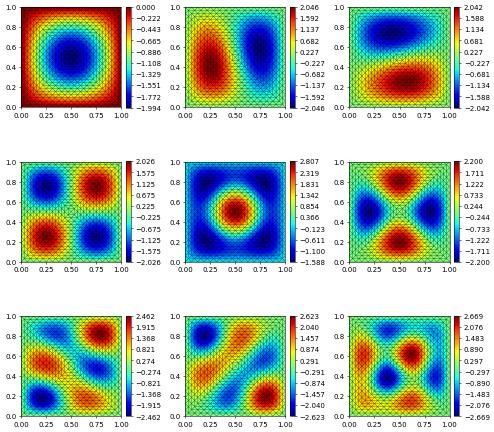

In [15]:
for k in range(num_sols):
    solutions[k].as_numpy[:] = eigvecs[:,k].real
# gridView.writeVTK( "Dirichlet_Eigenvalues", pointdata = solutions )
rows, cols = num_sols//3, 3
fig, axs = plt.subplots(rows, cols, figsize=(10,10))
for k in range(rows):
    for l in range(cols):
        if k*cols+l < len(solutions):
            solutions[k*cols+l].plot( figure=(fig, axs[k][l]) )